In [15]:
BASE_DIR = "/home/kyudan/AnomLLM"

In [20]:
import numpy as np
import pandas as pd
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score

def evaluate_multi_label(y_true, y_pred):
    
    # 레이블 이름 설정
    label_names = ["Trend", "Seasonality", "Noise", "Anomalies"]
    
    # 개별 평가 지표 계산
    metrics = {
        # 전체 정확도 (모든 레이블이 정확히 일치하는 비율)
        'exact_match_ratio': accuracy_score(y_true, y_pred),
        
        # 해밍 손실 (잘못 예측된 레이블의 비율)
        'hamming_loss': hamming_loss(y_true, y_pred),
        
        # 자카드 유사도 (교집합/합집합)
        'jaccard_score': jaccard_score(y_true, y_pred, average='samples'),
        
        # 레이블별 정확도
        'label_accuracy': {},
        
        # 세부 지표 (마이크로 평균: 전체 데이터셋에 대한 지표)
        'micro_precision': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'micro_recall': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'micro_f1': f1_score(y_true, y_pred, average='micro', zero_division=0),
        
        # 세부 지표 (매크로 평균: 각 레이블에 대한 지표의 평균)
        'macro_precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'macro_recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'macro_f1': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }
    
    # 각 레이블별 정확도 계산
    for i, label in enumerate(label_names):
        label_true = y_true[:, i]
        label_pred = y_pred[:, i]
        metrics['label_accuracy'][label] = accuracy_score(label_true, label_pred)
    
    return metrics

def process_data(ground_truth_df, predictions_list):
    
    # 예측 결과에서 값 추출
    y_pred = []
    
    for pred_item in predictions_list:
        # JSON 응답에서 예측 결과 추출
        response = pred_item["response"]
        # JSON 형식 문자열 추출 (```json과 ```를 제거하고 파싱)
        json_str = response.strip().replace("```json", "").replace("```", "").strip()
        pred_dict = json.loads(json_str)
        
        # 순서대로 리스트로 변환 [Trend, Seasonality, Noise, Anomalies]
        pred_values = [
            pred_dict["Trend"], 
            pred_dict["Seasonality"], 
            pred_dict["Noise"], 
            pred_dict["Anomalies"]
        ]
        y_pred.append(pred_values)
    
    # Ground truth 데이터 추출
    y_true = []
    
    # 예측 결과 개수만큼 ground truth 데이터 가져오기
    # 주의: 이 부분은 예측 결과와 ground truth가 같은 순서로 정렬되어 있다고 가정합니다
    for i in range(len(y_pred)):
        if i < len(ground_truth_df):
            row = ground_truth_df.iloc[i]
            # [trend, seasonal, noise, has_anomaly]
            true_values = [
                row["trend"], 
                row["seasonal"], 
                row["noise"], 
                row["has_anomaly"]
            ]
            y_true.append(true_values)
    
    return np.array(y_true), np.array(y_pred)

def create_metrics_dataframe(metrics):
    # 1. 전체 지표를 DataFrame으로 변환
    overall_metrics = {
        'Metric': [
            'Exact Match Ratio',
            'Hamming Loss',
            'Jaccard Score',
            'Micro-Precision',
            'Micro-Recall',
            'Micro-F1',
            'Macro-Precision',
            'Macro-Recall',
            'Macro-F1'
        ],
        'Value': [
            metrics['exact_match_ratio'],
            metrics['hamming_loss'],
            metrics['jaccard_score'],
            metrics['micro_precision'],
            metrics['micro_recall'],
            metrics['micro_f1'],
            metrics['macro_precision'],
            metrics['macro_recall'],
            metrics['macro_f1']
        ]
    }
    
    overall_df = pd.DataFrame(overall_metrics)
    
   
    label_accuracy = {
        'Label': list(metrics['label_accuracy'].keys()),
        'Accuracy': list(metrics['label_accuracy'].values())
    }
    
    label_df = pd.DataFrame(label_accuracy)
    
    return overall_df, label_df

def main():
    
    gt_df = pd.read_pickle("../data/synthetic/component_series_400.pkl")
    
    predictions = []
    with open(f"{BASE_DIR}/results/data/synthetic/component_series_400.pkl/gemini-1.5-flash/component.jsonl", "r") as f:
        for line in f:
            predictions.append(json.loads(line.strip()))
    
    # 3. 데이터 처리
    y_true, y_pred = process_data(gt_df, predictions)
    
    # debug
    print("len(y_true), len(y_pred)", len(y_true), len(y_pred))
    
    # 4. 평가 지표 계산
    metrics = evaluate_multi_label(y_true, y_pred)
    
    # 5. 결과를 DataFrame으로 변환
    overall_metrics_df, label_accuracy_df = create_metrics_dataframe(metrics)
    
    # 6. 결과 출력
    print(f"데이터 샘플 수: {len(y_true)}")
    
    print("\n===== 전체 평가 지표 =====")
    print(overall_metrics_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    
    print("\n===== 레이블별 정확도 =====")
    print(label_accuracy_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    
    # 7. DataFrame을 CSV로 저장 (옵션)
    overall_metrics_df.to_csv("overall_metrics.csv", index=False)
    label_accuracy_df.to_csv("label_accuracy.csv", index=False)
    
    # 8. 통합된 DataFrame 반환 (필요시 사용)
    combined_results = {
        'sample_count': len(y_true),
        'overall_metrics': overall_metrics_df,
        'label_accuracy': label_accuracy_df
    }
    
    return combined_results

In [21]:

results = main()

# 결과 DataFrame 직접 사용 예시
overall_df = results['overall_metrics']
label_df = results['label_accuracy']

len(y_true), len(y_pred) 400 400
데이터 샘플 수: 400

===== 전체 평가 지표 =====
           Metric  Value
Exact Match Ratio 0.4375
     Hamming Loss 0.1994
    Jaccard Score 0.7281
  Micro-Precision 0.8014
     Micro-Recall 0.8288
         Micro-F1 0.8149
  Macro-Precision 0.8214
     Macro-Recall 0.8214
         Macro-F1 0.7994

===== 레이블별 정확도 =====
      Label  Accuracy
      Trend    0.9075
Seasonality    0.9925
      Noise    0.6425
  Anomalies    0.6600


In [22]:
overall_df

,Metric,Value
0,Exact Match Ratio,0.437500
1,Hamming Loss,0.199375
2,Jaccard Score,0.728125
3,Micro-Precision,0.801370
4,Micro-Recall,0.828808
5,Micro-F1,0.814858
6,Macro-Precision,0.821379
7,Macro-Recall,0.821416
8,Macro-F1,0.799353


(0.0, 1.0)

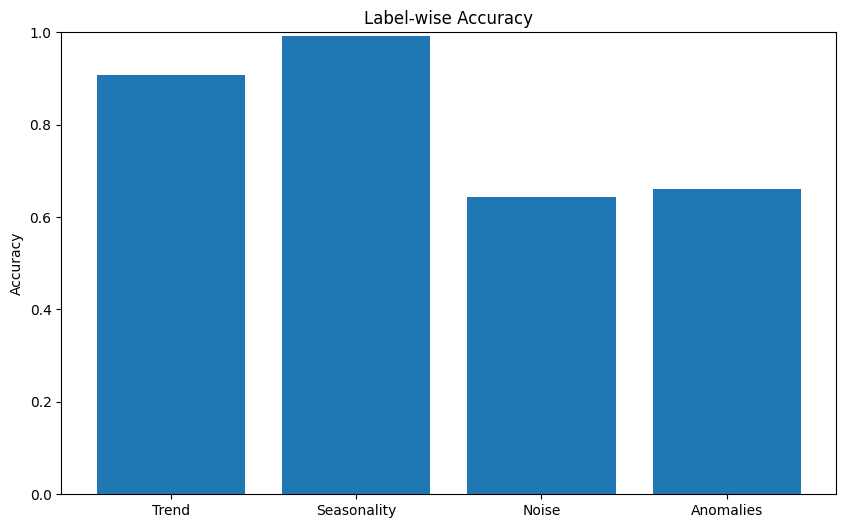

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(label_df['Label'], label_df['Accuracy'])
plt.title('Label-wise Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
#plt.savefig('label_accuracy.png')